In [1]:
import sys
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("..")
from src.utils.plotting import plot_traj
from src.utils.config import SEEDS, L2_REG, LRS

In [2]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams["axes.labelsize"] = 34
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 32
mpl.rcParams['text.usetex'] = True

In [3]:
seeds = SEEDS
l2_reg = L2_REG

In [4]:
plot_cfgs = [
    {
        "optimizer": "sgd",
        "label": "SGD",
        "color": "black",
        "linestyle": "solid"
    },
    {
        "optimizer": "srda",
        "label": "SRDA",
        "color": "tab:blue",
        "linestyle": "solid"
    },
    # {
    #     "optimizer": "lsvrg",
    #     "label": "L-SVRG (Non-uniform)",
    #     "color": "tab:red",
    #     "linestyle": "solid",
    #     "superquantile": {
    #         "lr": LRS[2],
    #         "epoch_len": 100,
    #     },
    #     "extremile": {
    #         "lr": LRS[2],
    #         "epoch_len": 100,
    #     },
    #     "esrm": {
    #         "lr": LRS[3],
    #         "epoch_len": 100,
    #     }
    # },
    {
        "optimizer": "lsvrg_uniform",
        "label": "L-SVRG",
        "color": "tab:red",
        "linestyle": "solid",
        "extremile": {
            "lr": LRS[2],
            "epoch_len": 100,
        },
        "esrm": {
            "lr": LRS[3],
            "epoch_len": 100,
        }
    },
    # Smoothed optimizers.
    # {
    #     "optimizer": "slsvrg_l2",
    #     "label": "L2-Smoothed L-SVRG",
    #     "color": "tab:green",
    #     "linestyle": "solid"
    # },
    # {
    #     "optimizer": "slsvrg_neg_ent",
    #     "label": "NegEnt-Smoothed L-SVRG",
    #     "color": "orange",
    #     "linestyle": "solid"
    # },
]

## Training Curves

Plots of suboptimality against number of epochs.

/home/ronak/orm/notebooks/../src/utils/plotting.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  subopt = torch.tensor(
/home/ronak/orm/notebooks/../src/utils/plotting.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  subopt = torch.tensor(


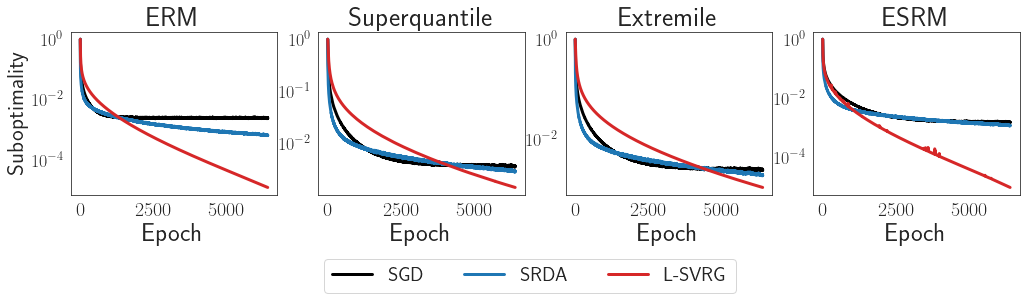

In [5]:
sns.set_style("white")

fig, axes = plt.subplots(1, 4, figsize=(17, 3))

dataset = "iwildcam_std"
objectives = [
    "erm", 
    "superquantile", 
    "extremile", 
    "esrm"
]


for j, objective in enumerate(objectives):
    model_cfg = {"objective": objective, "l2_reg": l2_reg, "loss": "multinomial_cross_entropy", "n_class": 60}
    for plot_cfg in plot_cfgs:
        plot_traj(axes[j], dataset , model_cfg, plot_cfg, seeds, plot_all=False)
    axes[j].set_yscale("log")

axes[0].set_title("ERM", fontsize=27)
axes[1].set_title("Superquantile", fontsize=27)
axes[2].set_title("Extremile", fontsize=27)
axes[3].set_title("ESRM", fontsize=27)

axes[0].set_xlabel("Epoch", fontsize=25)
axes[1].set_xlabel("Epoch", fontsize=25)
axes[2].set_xlabel("Epoch", fontsize=25)
axes[3].set_xlabel("Epoch", fontsize=25)

axes[0].set_ylabel("Suboptimality", fontsize=23)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center',
            bbox_to_anchor=(0.5, -0.25), ncol=4)
plt.savefig("../figures/iwildcam_training_curve.pdf", bbox_inches="tight")
plt.show()

## Robustness

Plots of ERM test loss quantiles against that of the various $L$-risk minimizers.

In [6]:
import pickle
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

sys.path.append("..")
from src.utils.io import get_path, var_to_str
from src.utils.config import L2_REG
from src.utils.data import load_dataset
from src.optim.objective import multinomial_cross_entropy_loss, squared_error_loss

In [7]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams["axes.labelsize"] = 26
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['text.usetex'] = True

In [8]:
out_path="../results/"
dataset = "iwildcam_std"
l2_reg = L2_REG
n_class = 60

In [9]:
def load_test_set(data_path):
    X_train = torch.tensor(
        np.load(os.path.join(data_path, "iwildcam/X_train.npy")),
        dtype=torch.float64,
    )
    y_train = torch.tensor(np.load(os.path.join(data_path, "iwildcam/y_train.npy")))
    X_test = torch.tensor(
        np.load(os.path.join(data_path, "iwildcam/X_test.npy")),
        dtype=torch.float64,
    )
    y_test = torch.tensor(
        np.load(os.path.join(data_path, "iwildcam/y_test.npy"))
    )

    return X_train, y_train, X_test, y_test

In [10]:
def get_weights(optimizer, objective):
    model_cfg = {"objective": objective, "l2_reg": l2_reg, "loss": "multinomial_cross_entropy", "n_class": n_class}
    path = get_path([dataset, var_to_str(model_cfg), optimizer], out_path=out_path)
    return pickle.load(open(os.path.join(path, "best_weights.p"), "rb"))

def get_losses(optimizer, objective, dataset, use_test=False):
    if use_test:
        X_train, y_train, X_val, y_val = load_test_set("../data/")
    else:
        X_train, y_train, X_val, y_val = load_dataset(dataset, data_path="../data/")
    w = get_weights(optimizer, objective)
    return multinomial_cross_entropy_loss(w, X_val, y_val, n_class).detach().numpy()

In [11]:
optimizer = "lsvrg_uniform"
objectives = {
    "erm": "tab:red", 
    "superquantile_lite": "tab:blue", 
    "extremile_lite": "tab:purple", 
    "esrm_lite": "tab:green"
}
objectives = {
    "erm": "tab:red", 
    "superquantile": "tab:blue", 
    "extremile": "tab:purple", 
    "esrm": "tab:green"
}

titles = {
    "superquantile_lite": "Superquantile", 
    "extremile_lite": "Extremile", 
    "esrm_lite": "ESRM",
    "superquantile": "Superquantile", 
    "extremile": "Extremile", 
    "esrm": "ESRM"
}

use_test = False # Toggle between test and validation loss.


In [12]:
losses = {objective: get_losses(optimizer, objective, dataset, use_test=use_test) for objective in objectives}

In [13]:
def create_ax(ax, objective, losses, trim=5):
    if trim:
        diffs = (np.sort(losses["erm"]) - np.sort(losses[objective]))[trim:-trim]
    else:
        diffs = (np.sort(losses["erm"]) - np.sort(losses[objective]))
    diffs = diffs + 0.005* np.random.normal(size=(len(diffs)))
    for i, diff in enumerate(diffs):
        if diff > 0:
            ax.vlines((i + 1) / len(diffs), ymin=0.0, ymax=diff, color=objectives[objective])
        else:
            ax.vlines((i + 1) / len(diffs), ymin=diff, ymax=0.0, color=objectives[objective])
    ax.set_title(titles[objective], fontsize=34)

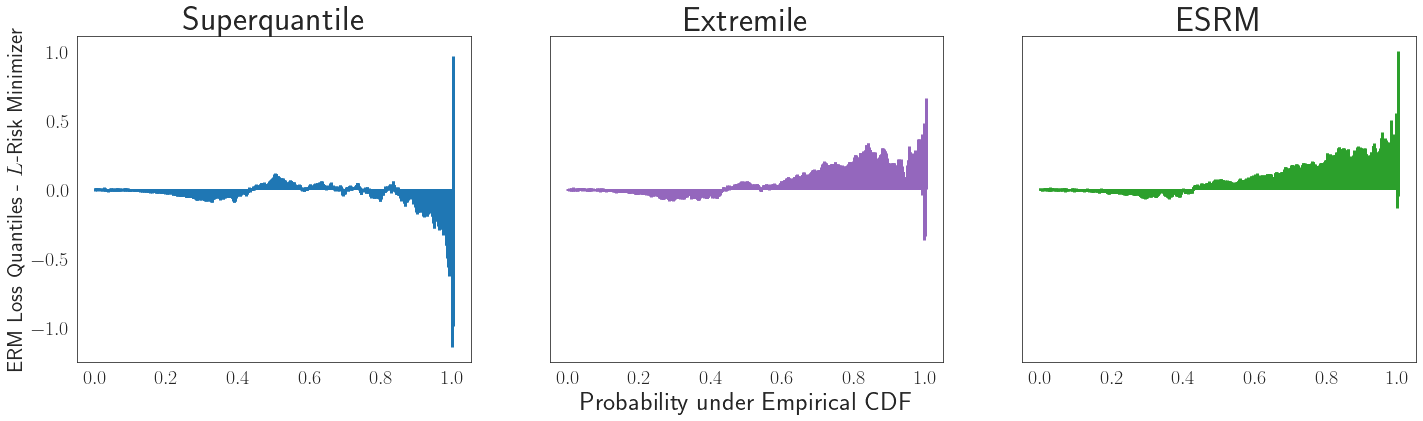

In [14]:
sns.set_style("white")

fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey=True)

trim = 0


# create_ax(axes[0], "superquantile_lite", losses, trim=trim)
# create_ax(axes[1], "extremile_lite", losses, trim=trim)
# create_ax(axes[2], "esrm_lite", losses, trim=trim)
create_ax(axes[0], "superquantile", losses, trim=trim)
create_ax(axes[1], "extremile", losses, trim=trim)
create_ax(axes[2], "esrm", losses, trim=trim)

# axes[0].set_yticks([])
axes[0].set_ylabel(r"ERM Loss Quantiles - $L$-Risk Minimizer", fontsize=22)
axes[1].set_xlabel(r"Probability under Empirical CDF")
# plt.savefig("../figures/iwildcam_risk_diff.pdf", bbox_inches="tight")
plt.show()
